# Tweet emotion Recognition

In [1]:
import pandas as pd # Data analysis library
import pickle
import numpy as np
#import nlp
# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split

%matplotlib inline
fig_params={'legend.fontsize':18,
          'axes.labelsize': 18,
          'axes.titlesize':20,
          'xtick.labelsize':16,
          'ytick.labelsize':16,             
          'axes.facecolor':'#D9DDD1'}
plt.rcParams.update(fig_params)

In [2]:
#dataset=nlp.load_dataset('emotion')

In [3]:
#dataset

In [4]:
df=pd.read_pickle('./data/merged_training.pkl')

In [5]:
df.head()

,text,emotions
27383,i feel awful about it too because it s my job ...,sadness
110083,im alone i feel awful,sadness
140764,ive probably mentioned this before but i reall...,joy
100071,i was feeling a little low few days back,sadness
2837,i beleive that i am much more sensitive to oth...,love


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 416809 entries, 27383 to 64703
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   text      416809 non-null  object
 1   emotions  416809 non-null  object
dtypes: object(2)
memory usage: 9.5+ MB


In [7]:
df['emotions'].unique()

array(['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'],
      dtype=object)

<AxesSubplot:>

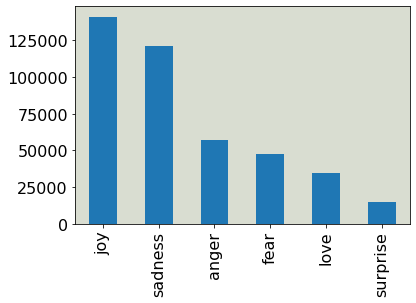

In [8]:
df['emotions'].value_counts().plot(kind='bar')

Let's create test,train and validation datasets from the above dataset.

In [9]:
X=df['text'];y=df['emotions']

In [10]:
tweet_tmp,tweet_ts,y_tmp,y_ts=train_test_split(X,y,test_size=0.8,random_state=42)
tweet_tr,tweet_cv,y_tr,y_cv=train_test_split(tweet_tmp,y_tmp,test_size=0.7,random_state=42)

In [11]:
df_train=pd.concat([tweet_tr,y_tr],axis=1)
df_val=pd.concat([tweet_cv,y_cv],axis=1)
df_test=pd.concat([tweet_ts,y_ts],axis=1)

In [12]:
pickle.dump(df_train,open('./data/train.pkl','wb'))
pickle.dump(df_test,open('./data/test.pkl','wb'))
pickle.dump(df_val,open('./data/validation.pkl','wb'))

## Tokenization

In [13]:
def clean_text(text):
    text = text.lower()
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(pattern='\n', repl=' ', string=text)
    text = re.sub(pattern='\t', repl=' ', string=text)
    text = re.sub('[0-9]', '', text)
    return text


def remove_stopwords_stemming(stemmer, text,need_stemming=True):
    if bool(need_stemming)==True:
        text_ret = [
            stemmer.stem(word.lower()) for word in text.split()
            if word.lower() not in stopwords.words('english')
        ]
    else:
        text_ret = [
            word.lower() for word in text.split()
            if word.lower() not in stopwords.words('english')
        ]
    return ' '.join(text_ret)


def stemming(stemmer, text):
    list = [stemmer.stem(word) for word in text.split()]
    return ' '.join(list)


def text_processing(text):
    text = clean_text(text)
    text = remove_stopwords_stemming(stemmer,text,need_stemming=True)
    #text=stemming(stemmer,text)
    return text

In [14]:
stemmer=SnowballStemmer(language='english')

In [15]:
df_train['processed']=df_train['text'].apply(lambda x:text_processing(x))

In [16]:
df_train

,text,emotions,processed
51093,i feel like the only defense for it is ignoran...,joy,feel like defens ignor compar detroit citi lik...
30929,i mean im not feeling so scared about it but m...,fear,mean im feel scare excit
119805,ive been in this state of just doing what i ha...,sadness,ive state without feel emot tie feel chang life
92861,i stubbornly refuse to give up even though it ...,sadness,stubborn refus give even though feel awkward
6804,i enjoy my job of the time and feel blessed to...,love,enjoy job time feel bless abl work full time h...
...,...,...,...
26155,i feel since all the armies are distracted wit...,anger,feel sinc armi distract purpl republ
82576,i moved in and scooped her up and she lay her ...,sadness,move scoop lay head shoulder clear feel defeat...
18186,i feel pretty shy about photos of myself espec...,fear,feel pretti shi photo especi right
42091,i won t feel quite so suspicious of the power ...,fear,feel quit suspici power struggl within local c...


In [17]:
df_train.describe()

,text,emotions,processed
count,25008,25008,25008
unique,24917,6,24671
top,i feel quite smug,joy,feel vain
freq,2,8477,6


In [20]:
df_train['length_text']=df_train['text'].apply(lambda x:len(x.split()))
df_train['length_processed']=df_train['processed'].apply(lambda x:len(x.split()))

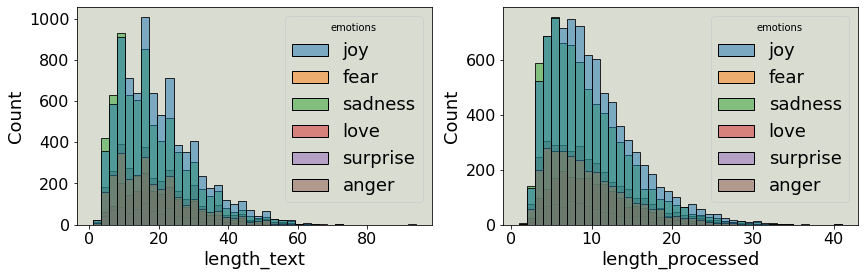

In [23]:
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(14,4))
sns.histplot(ax=ax[0],data=df_train,x='length_text',hue='emotions',bins=40)
sns.histplot(ax=ax[1],data=df_train,x='length_processed',hue='emotions',bins=40)
plt.show()

In [25]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [26]:
tokenizer=Tokenizer(num_words=12000,oov_token='<UKN>')
tokenizer.fit_on_texts(df_train['processed'])

In [27]:
def get_sequence(tokenizer,text,maxlen):
    sequence=tokenizer.texts_to_sequences([text])
    padded=pad_sequences(sequences=sequence,maxlen=maxlen,padding='post',truncating='post')
    return padded

In [28]:
df_train['padded_seq'] = np.squeeze(df_train['processed'].apply(
    lambda x: get_sequence(tokenizer=tokenizer, text=x, maxlen=30)))

In [29]:
df_train['padded_seq']

51093     [[2, 3, 1922, 297, 924, 4950, 889, 3, 924, 566...
30929     [[179, 4, 2, 228, 140, 0, 0, 0, 0, 0, 0, 0, 0,...
119805    [[22, 470, 93, 2, 105, 1699, 2, 168, 25, 0, 0,...
92861     [[845, 1049, 72, 21, 58, 2, 381, 0, 0, 0, 0, 0...
6804      [[155, 223, 7, 2, 141, 98, 32, 365, 7, 220, 18...
                                ...                        
26155     [[2, 122, 2550, 451, 2736, 4813, 0, 0, 0, 0, 0...
82576     [[222, 4308, 978, 200, 1399, 791, 2, 476, 386,...
18186     [[2, 38, 495, 681, 190, 43, 0, 0, 0, 0, 0, 0, ...
42091     [[2, 60, 752, 712, 408, 472, 1257, 708, 60, 83...
34798     [[26, 30, 138, 299, 29, 41, 129, 511, 1036, 12...
Name: padded_seq, Length: 25008, dtype: object

In [30]:
from sklearn.preprocessing import LabelEncoder

In [31]:
le=LabelEncoder()

In [35]:
le.fit(df_train['emotions'])

LabelEncoder()

In [38]:
le.transform(df_train['emotions'])

array([2, 1, 4, ..., 1, 1, 0])